In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import shutil
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, MaxPooling2D 
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
# Creating mixed emotion folders
base_path = r"C:\Users\User\Desktop\images"
train_path = os.path.join(base_path, "train")
validation_path = os.path.join(base_path, "validation")
train_combo_path = os.path.join(base_path, "train_combo")
validation_combo_path = os.path.join(base_path, "validation_combo")

# Creating destination folders
os.makedirs(train_combo_path, exist_ok=True)
os.makedirs(validation_combo_path, exist_ok=True)

In [5]:
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
num_images_per_emotion_train_combo = 200
num_images_per_emotion_validation_combo = 100

for emotion in emotions:
  # Train data
  source_path = os.path.join(train_path, emotion)
  destination_path = os.path.join(train_combo_path, emotion)
  os.makedirs(destination_path, exist_ok=True)

  # Check if directory exists and has enough images
  if not os.path.exists(source_path):
    print(f"Warning: Directory '{source_path}' does not exist.")
    continue

  num_images_in_source = len(os.listdir(source_path))
  if num_images_in_source < num_images_per_emotion_train:
    print(f"Warning: Directory '{source_path}' has fewer images ({num_images_in_source}) than desired ({num_images_per_emotion_train}).")
    num_images_per_emotion_train = min(num_images_in_source, num_images_per_emotion_train)

  # Copying desired number of images
  for i in range(num_images_per_emotion_train):
    filename = os.listdir(source_path)[i]
    source = os.path.join(source_path, filename)
    destination = os.path.join(destination_path, filename)
    copyfile(source, destination)

  # Validation data
  source_path = os.path.join(validation_path, emotion)
  destination_path = os.path.join(validation_combo_path, emotion)
  os.makedirs(destination_path, exist_ok=True)

  # Check if directory exists and has enough images
  if not os.path.exists(source_path):
    print(f"Warning: Directory '{source_path}' does not exist.")
    continue

  num_images_in_source = len(os.listdir(source_path))
  if num_images_in_source < num_images_per_emotion_validation:
    print(f"Warning: Directory '{source_path}' has fewer images ({num_images_in_source}) than desired ({num_images_per_emotion_validation}).")
    num_images_per_emotion_validation = min(num_images_in_source, num_images_per_emotion_validation)

  # Copying desired number of images
  for i in range(num_images_per_emotion_validation):
    filename = os.listdir(source_path)[i]
    source = os.path.join(source_path, filename)
    destination = os.path.join(destination_path, filename)
    copyfile(source, destination)

In [6]:
# Data preparation and Model training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Defining training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_combo_path,
    target_size=(48, 48),  
    batch_size=32,
    class_mode='categorical'  
)

validation_generator = validation_datagen.flow_from_directory(
    validation_combo_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7059 images belonging to 7 classes.


In [7]:
# Defining the model architecture
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(64, activation='relu'),  # Adjust number of units based on complexity
  Dense(7, activation='softmax')  # 7 output units for 7 emotions
])

# Compiling the model (specifying optimizer and loss function)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Training the model with Early Stopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)  
 
model.fit(
  train_generator,
  epochs=30, 
  validation_data=validation_generator,
  callbacks=[early_stopping]
)

Epoch 1/30
901/901 [==============================] - 61s 67ms/step - loss: 1.6267 - accuracy: 0.3636 - val_loss: 1.4686 - val_accuracy: 0.4397
Epoch 2/30
901/901 [==============================] - 61s 68ms/step - loss: 1.4549 - accuracy: 0.4409 - val_loss: 1.3525 - val_accuracy: 0.4829
Epoch 3/30
901/901 [==============================] - 68s 75ms/step - loss: 1.3697 - accuracy: 0.4743 - val_loss: 1.3489 - val_accuracy: 0.4858
Epoch 4/30
901/901 [==============================] - 74s 82ms/step - loss: 1.3204 - accuracy: 0.4953 - val_loss: 1.2822 - val_accuracy: 0.5106
Epoch 5/30
901/901 [==============================] - 70s 77ms/step - loss: 1.2808 - accuracy: 0.5119 - val_loss: 1.2512 - val_accuracy: 0.5222
Epoch 6/30
901/901 [==============================] - 67s 75ms/step - loss: 1.2459 - accuracy: 0.5235 - val_loss: 1.2533 - val_accuracy: 0.5226
Epoch 7/30
901/901 [==============================] - 68s 75ms/step - loss: 1.2236 - accuracy: 0.5331 - val_loss: 1.2129 - val_accuracy:

In [10]:
def evaluate_model(model, data_generator, steps):
    # Initialize metrics
    precision = Precision()
    recall = Recall()
    class_labels = {
        "angry": 0,
        "disgust": 1,
        "fear": 2,
        "happy": 3,
        "neutral": 4,
        "sad": 5,
        "surprise": 6
    }

    # Evaluating the model using the data generator
    loss, accuracy = model.evaluate(data_generator, steps=steps)

    # Collecting predictions and true labels during evaluation
    predicted_labels = []
    true_labels = []

    # Iterating over the data generator
    for _ in range(steps):
        batch_images, batch_labels = next(data_generator)
        batch_preds = model.predict(batch_images)
        predicted_labels.extend(np.argmax(batch_preds, axis=1))
        true_labels.extend(np.argmax(batch_labels, axis=1))

    # Updating metrics with collected labels and predictions
    precision.update_state(true_labels, predicted_labels)
    recall.update_state(true_labels, predicted_labels)
    f1_score = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())

    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision.result():.4f}")
    print(f"Recall: {recall.result():.4f}")
    print(f"F1-Score: {f1_score:.4f}")

steps_per_epoch = len(validation_generator)
evaluate_model(model, validation_generator, steps=steps_per_epoch)

1/1 [==============================] - 0s 94ms/step
Loss: 1.2057, Accuracy: 0.5647
Precision: 0.9063
Recall: 0.9439
F1-Score: 0.9248


In [11]:
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(64, activation='relu'),  
  Dense(7, activation='softmax')  
])

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
  train_generator,
  epochs=10,  
  validation_data=validation_generator
)

history = model.history
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Epoch 1/10
901/901 [==============================] - 67s 73ms/step - loss: 1.6794 - accuracy: 0.3329 - val_loss: 1.5382 - val_accuracy: 0.4105
Epoch 2/10
901/901 [==============================] - 67s 75ms/step - loss: 1.5151 - accuracy: 0.4126 - val_loss: 1.4557 - val_accuracy: 0.4444
Epoch 3/10
901/901 [==============================] - 66s 74ms/step - loss: 1.4401 - accuracy: 0.4450 - val_loss: 1.3861 - val_accuracy: 0.4716
Epoch 4/10
901/901 [==============================] - 70s 78ms/step - loss: 1.3853 - accuracy: 0.4701 - val_loss: 1.3180 - val_accuracy: 0.4971
Epoch 5/10
901/901 [==============================] - 67s 74ms/step - loss: 1.3432 - accuracy: 0.4839 - val_loss: 1.3018 - val_accuracy: 0.5066
Epoch 6/10
901/901 [==============================] - 70s 78ms/step - loss: 1.3090 - accuracy: 0.4984 - val_loss: 1.2695 - val_accuracy: 0.5202
Epoch 7/10
901/901 [==============================] - 62s 68ms/step - loss: 1.2888 - accuracy: 0.5110 - val_loss: 1.2708 - val_accuracy:

In [13]:
# Applying data augmentation to training images

train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=(-0.3, 0.3)
)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\User\Desktop\images\train",  
    target_size=(48, 48),
    batch_size=32,
    class_mode="categorical"
)

Found 0 images belonging to 7 classes.


Predicted Emotion for C:\Users\User\Desktop\happy_face_bw.jpg: angry


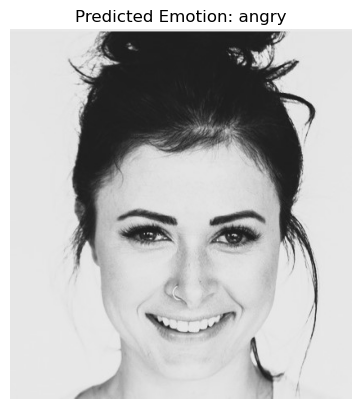

Predicted Emotion for C:\Users\User\Desktop\happy_face-bw.jpg: surprise


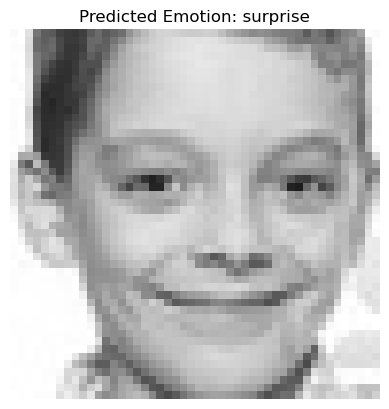

Predicted Emotion for C:\Users\User\Desktop\neutral_face_bw.jpg: fear


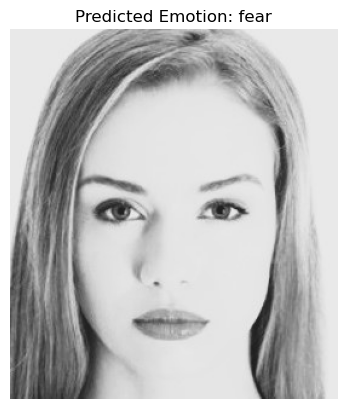

Predicted Emotion for C:\Users\User\Desktop\neutral_face-bw.jpg: surprise


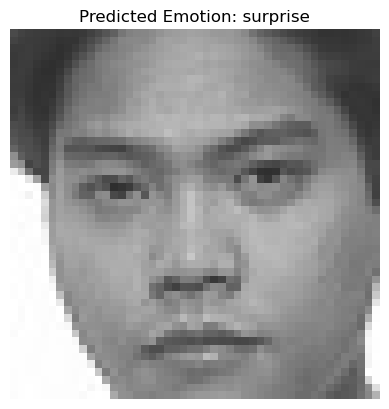

Predicted Emotion for C:\Users\User\Desktop\sad_face_bw.jpg: sad


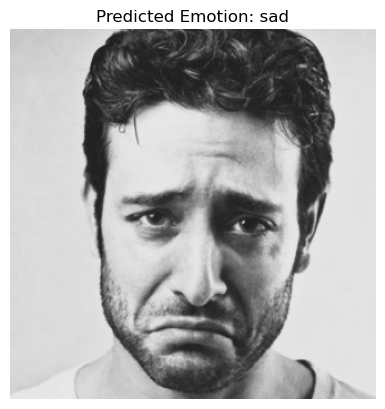

Predicted Emotion for C:\Users\User\Desktop\sad_face-bw.jpg: surprise


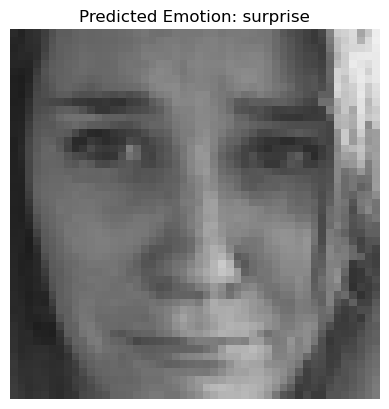

Predicted Emotion for C:\Users\User\Desktop\surprise_face_bw.jpg: happy


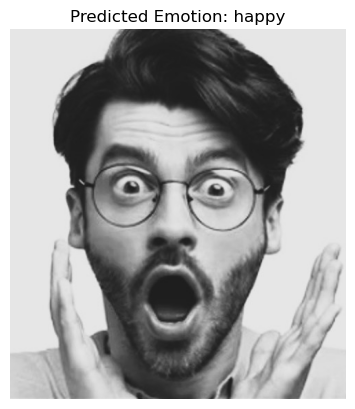

Predicted Emotion for C:\Users\User\Desktop\surprise_face-bw.jpg: angry


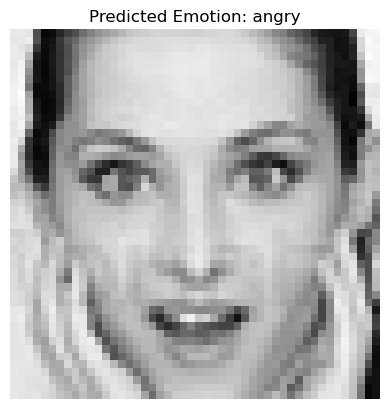

Predicted Emotion for C:\Users\User\Desktop\angry_face_bw.jpg: disgust


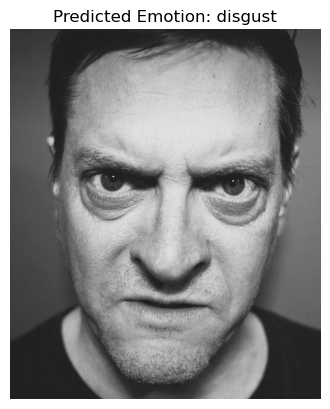

Predicted Emotion for C:\Users\User\Desktop\angry_face-bw.jpg: fear


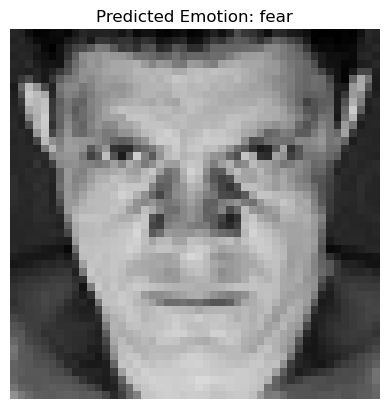

Predicted Emotion for C:\Users\User\Desktop\fear_face_bw.jpg: surprise


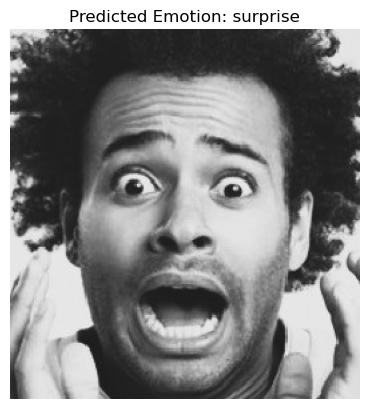

Predicted Emotion for C:\Users\User\Desktop\fear_face-bw.jpg: surprise


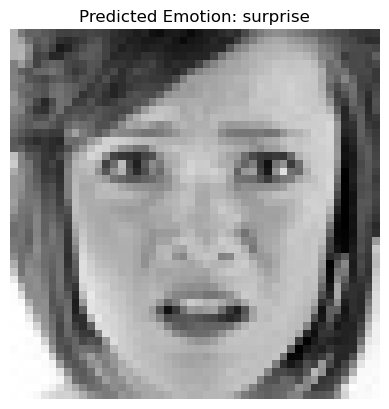

Predicted Emotion for C:\Users\User\Desktop\disgust_face_bw.jpg: sad


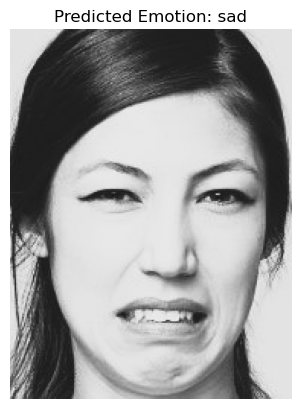

Predicted Emotion for C:\Users\User\Desktop\disgust_face-bw.jpg: angry


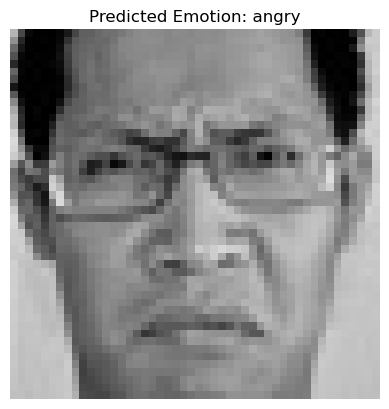

In [8]:
from keras.preprocessing.image import load_img, img_to_array
from PIL import ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Replace with your actual trained emotion recognition model
def predict_emotion(preprocessed_image):
    # Example: Replace with your model prediction logic
    # This function should return an array of probabilities for each emotion class
    # For demonstration, let's assume some random probabilities
    num_classes = 7
    return np.random.rand(1, num_classes)

def load_and_preprocess_image(image_path, target_size=(48, 48)):
    # Load the image
    image = load_img(image_path, target_size=target_size)
    # Convert the image to an array
    image_array = img_to_array(image)
    # Expand dimensions to match the model input shape (batch_size, height, width, channels)
    image_array = np.expand_dims(image_array, axis=-1)  # Add channel dimension for grayscale
    # Scale the pixel values to [0, 1]
    image_array = image_array / 255.0
    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Example usage:
image_paths = [
    r"C:\Users\User\Desktop\happy_face_bw.jpg",
    r"C:\Users\User\Desktop\happy_face-bw.jpg",
    r"C:\Users\User\Desktop\neutral_face_bw.jpg",
    r"C:\Users\User\Desktop\neutral_face-bw.jpg",
    r"C:\Users\User\Desktop\sad_face_bw.jpg",
    r"C:\Users\User\Desktop\sad_face-bw.jpg",
    r"C:\Users\User\Desktop\surprise_face_bw.jpg",
    r"C:\Users\User\Desktop\surprise_face-bw.jpg",
    r"C:\Users\User\Desktop\angry_face_bw.jpg",
    r"C:\Users\User\Desktop\angry_face-bw.jpg",
    r"C:\Users\User\Desktop\fear_face_bw.jpg",
    r"C:\Users\User\Desktop\fear_face-bw.jpg",
    r"C:\Users\User\Desktop\disgust_face_bw.jpg",
    r"C:\Users\User\Desktop\disgust_face-bw.jpg"
]

for image_path in image_paths:
    # Load and preprocess the image
    preprocessed_image = load_and_preprocess_image(image_path)

    # Get model predictions
    predictions = predict_emotion(preprocessed_image)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions[0])

    # Emotion categories (replace with your actual categories)
    categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
    predicted_emotion = categories[predicted_class_index]

    # Print the prediction
    print(f"Predicted Emotion for {image_path}: {predicted_emotion}")

    # Display the image and prediction
    plt.figure()
    plt.imshow(load_img(image_path))
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis('off')  # Hide the axes
    plt.show()